In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from scipy.stats import randint as sp_randint, uniform as sp_uniform
from sklearn.preprocessing import StandardScaler
import time



In [3]:
df_train = pd.read_csv("../regression_train.csv")
df_test = pd.read_csv("../regression_test.csv")

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9254 entries, 0 to 9253
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   region                   9254 non-null   int64  
 1   period_begin             9254 non-null   object 
 2   homes_sold               9254 non-null   float64
 3   inventory                9254 non-null   float64
 4   median_dom               9254 non-null   float64
 5   off_market_in_two_weeks  9254 non-null   float64
 6   avg_sale_to_list         9254 non-null   float64
 7   sold_above_list          9254 non-null   float64
 8   median_sale_price_mom    9254 non-null   float64
 9   median_sale_price_yoy    9254 non-null   float64
 10  homes_sold_mom           9254 non-null   float64
 11  homes_sold_yoy           9254 non-null   float64
 12  inventory_mom            9254 non-null   float64
 13  inventory_yoy            9254 non-null   float64
 14  median_dom_mom          

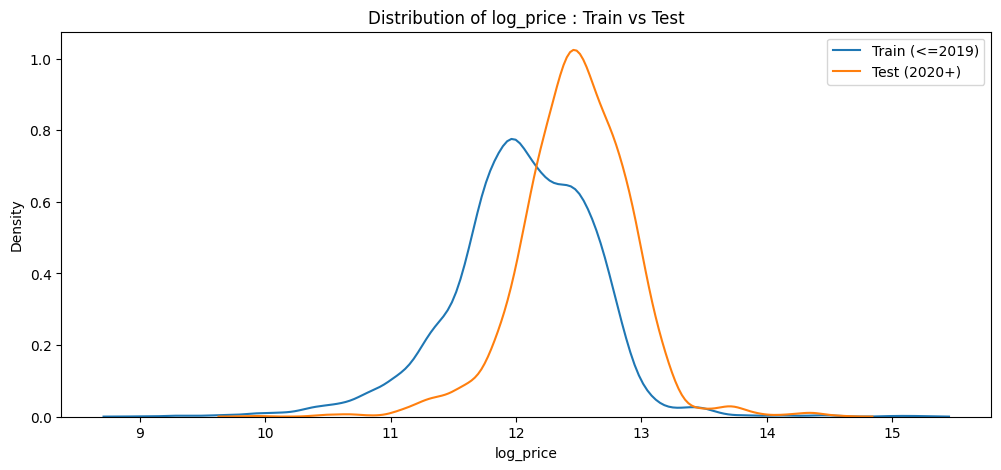

In [5]:
plt.figure(figsize=(12, 5))

sns.kdeplot(df_train['log_price'], label='Train (<=2019)')
sns.kdeplot(df_test['log_price'], label='Test (2020+)')

plt.title("Distribution of log_price : Train vs Test")
plt.xlabel("log_price")
plt.ylabel("Density")
plt.legend()
plt.show()

In [6]:

TARGET_COL = 'log_price'
features = [
    'homes_sold', 'inventory', 'median_dom', 'avg_sale_to_list', 'sold_above_list',
    'median_sale_price_mom', 'median_sale_price_yoy',
    'homes_sold_mom', 'homes_sold_yoy',
    'inventory_mom', 'inventory_yoy',
    'median_dom_mom', 'median_dom_yoy',
    'year', 'covid_era'
]
# , 'state_NC','Q_1', 'Q_2', 'Q_3', 'Q_4', 'off_market_in_two_weeks'


In [7]:
import pandas as pd

feature_stats = {}

for f in features:
    feature_stats[f] = {
        'train_mean': df_train[f].mean(),
        'test_mean': df_test[f].mean(),
        'train_std': df_train[f].std(),
        'test_std': df_test[f].std(),
    }

pd.DataFrame(feature_stats).T


,train_mean,test_mean,train_std,test_std
homes_sold,-9.213867e-18,0.211059,1.000054,1.153869
inventory,6.756836e-17,-0.439026,1.000054,0.556793
median_dom,8.753174e-17,-0.687386,1.000054,0.677102
avg_sale_to_list,1.200874e-15,0.759470,1.000054,0.833284
sold_above_list,1.904199e-16,1.223401,1.000054,1.320452
median_sale_price_mom,1.074951e-17,-0.024076,1.000054,0.492652
median_sale_price_yoy,-2.764160e-17,0.068475,1.000054,0.572765
homes_sold_mom,6.142578e-18,0.016428,1.000054,1.041082
homes_sold_yoy,5.528320e-17,0.086007,1.000054,1.165776
inventory_mom,6.142578e-18,-0.029696,1.000054,1.401660


test data has no historical parallel with training years.

In [8]:

# X = df_train[features]
# y = df_train[TARGET_COL]

# X_train, X_test, y_train, y_test = train_test_split(
#     X, 
#     y, 
#     test_size=0.20, # 20% for validation
#     random_state=42,
#     shuffle=True 
# )

In [9]:

X_train = df_train[features]
y_train = df_train[TARGET_COL]

X_test = df_test[features]
y_test = df_test[TARGET_COL]

print(f"Regression Target: {TARGET_COL}")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Number of Features: {len(features)}")


Regression Target: log_price
Training data shape: (9254, 15)
Testing data shape: (2511, 15)
Number of Features: 15


In [10]:

gbr_model = GradientBoostingRegressor(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3, 
    random_state=42
)

rf_model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    random_state=42, 
    n_jobs=-1
)

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

lr_model = LinearRegression()

start_time = time.time()
gbr_model.fit(X_train, y_train)
gbr_train_time = time.time() - start_time
print(f"GBR Training Time: {gbr_train_time:.2f} seconds")


start_time = time.time()
rf_model.fit(X_train, y_train)
rf_train_time = time.time() - start_time
print(f"RF Training Time: {rf_train_time:.2f} seconds")

start_time = time.time()
xgb_model.fit(X_train, y_train)
xgb_train_time = time.time() - start_time
print(f"XGB Training Time: {xgb_train_time:.2f} seconds")

start_time = time.time()
lr_model.fit(X_train, y_train)
lr_train_time = time.time() - start_time
print(f"LR Training Time: {lr_train_time:.2f} seconds")

GBR Training Time: 1.95 seconds
RF Training Time: 0.57 seconds
XGB Training Time: 0.19 seconds
LR Training Time: 0.01 seconds


In [11]:
def evaluate_regression_model(model, X_test, y_test):
    """Predicts, calculates R2, and calculates MAE/RMSE on the original scale."""
    
 
    y_pred_log = model.predict(X_test)

    r2 = r2_score(y_test, y_pred_log)

    y_test_price = np.exp(y_test)
    y_pred_price = np.exp(y_pred_log)

    mae_price = mean_absolute_error(y_test_price, y_pred_price)
    rmse_price = np.sqrt(mean_squared_error(y_test_price, y_pred_price))
    
    return r2, mae_price, rmse_price

# Evaluate Gradient Boosting Regressor
gbr_r2, gbr_mae, gbr_rmse = evaluate_regression_model(gbr_model, X_test, y_test)

print("\n--- Gradient Boosting Regressor Performance ---")
print(f"R2 Score (log_price): {gbr_r2:.4f}")
print(f"MAE (median_sale_price): ${gbr_mae:,.2f}")
print(f"RMSE (median_sale_price): ${gbr_rmse:,.2f}")

# Evaluate Random Forest Regressor
rf_r2, rf_mae, rf_rmse = evaluate_regression_model(rf_model, X_test, y_test)

print("\n--- Random Forest Regressor Performance ---")
print(f"R2 Score (log_price): {rf_r2:.4f}")
print(f"MAE (median_sale_price): ${rf_mae:,.2f}")
print(f"RMSE (median_sale_price): ${rf_rmse:,.2f}")

xgb_r2, xgb_mae, xgb_rmse = evaluate_regression_model(xgb_model, X_test, y_test)

print("\n--- XGBoost Regressor Performance ---")
print(f"R2 Score (log_price): {xgb_r2:.4f}")
print(f"MAE (median_sale_price): ${xgb_mae:,.2f}")
print(f"RMSE (median_sale_price): ${xgb_rmse:,.2f}")

lr_r2, lr_mae, lr_rmse = evaluate_regression_model(lr_model, X_test, y_test)
print("\n--- Linear Regressor Performance ---")
print(f"R2 Score (log_price): {lr_r2:.4f}")
print(f"MAE (median_sale_price): ${lr_mae:,.2f}")
print(f"RMSE (median_sale_price): ${lr_rmse:,.2f}")


--- Gradient Boosting Regressor Performance ---
R2 Score (log_price): -0.2162
MAE (median_sale_price): $102,669.91
RMSE (median_sale_price): $168,160.99

--- Random Forest Regressor Performance ---
R2 Score (log_price): -0.3133
MAE (median_sale_price): $105,764.91
RMSE (median_sale_price): $171,804.33

--- XGBoost Regressor Performance ---
R2 Score (log_price): -0.3901
MAE (median_sale_price): $107,943.49
RMSE (median_sale_price): $173,433.96

--- Linear Regressor Performance ---
R2 Score (log_price): 0.1499
MAE (median_sale_price): $84,044.02
RMSE (median_sale_price): $151,077.77


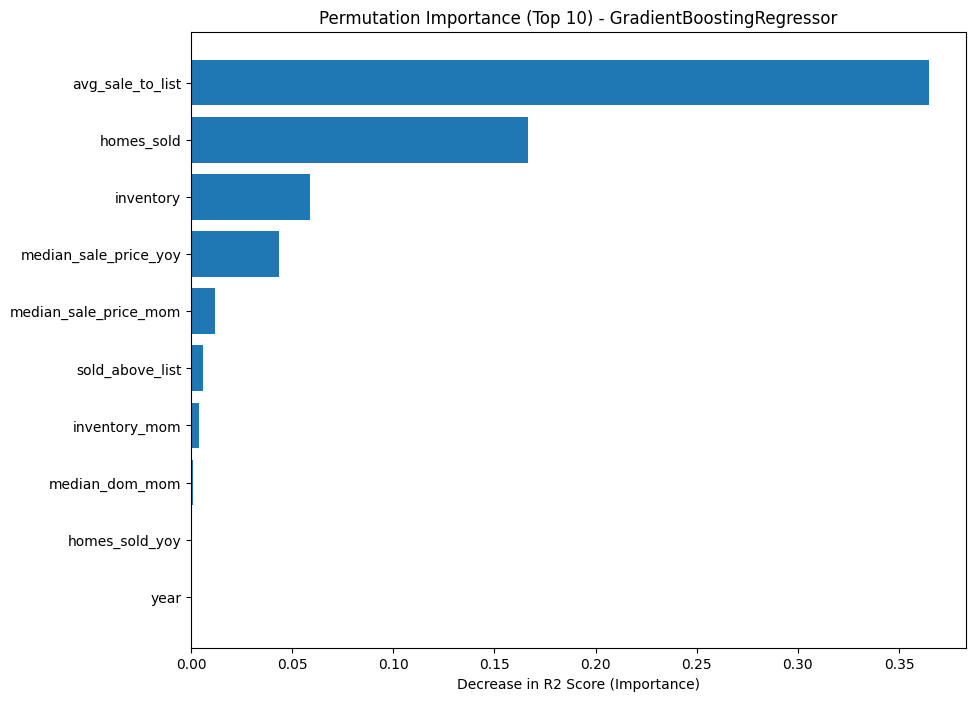

In [12]:

model_for_importance = gbr_model


results = permutation_importance(
    model_for_importance,   
    X_test,                 
    y_test,                 
    n_repeats=10,           
    random_state=42,
    n_jobs=-1
)

importances = results.importances_mean
feature_names = X_test.columns

importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)


top_n = 10
plt.figure(figsize=(10,8))
plt.barh(importance_df['feature'].head(top_n), importance_df['importance'].head(top_n))
plt.gca().invert_yaxis()
plt.title(f'Permutation Importance (Top {top_n}) - {model_for_importance.__class__.__name__}')
plt.xlabel('Decrease in R2 Score (Importance)')
plt.show()

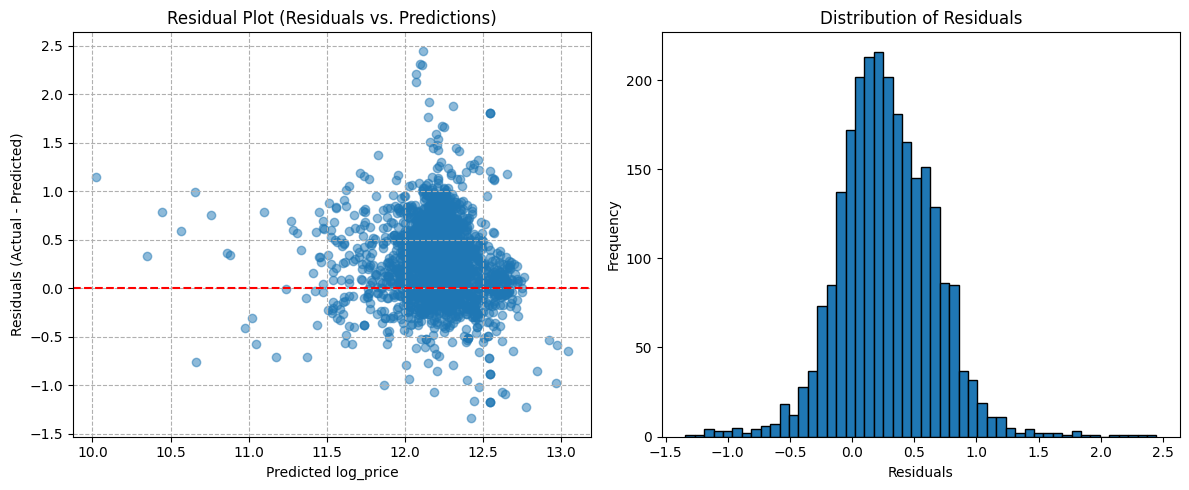

In [13]:

best_model = gbr_model 
y_pred_log = best_model.predict(X_test)
residuals = y_test - y_pred_log

plt.figure(figsize=(12, 5))

# Scatter Plot of Residuals vs. Predicted Values
plt.subplot(1, 2, 1)
plt.scatter(y_pred_log, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot (Residuals vs. Predictions)')
plt.xlabel(f'Predicted {TARGET_COL}')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True, linestyle='--')

# Histogram of Residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=50, edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



pre-covid dataset

--- Gradient Boosting Regressor Performance ---

R2 Score (log_price): 0.4535

MAE (median_sale_price): $65,931.94

RMSE (median_sale_price): $137,866.94



--- Random Forest Regressor Performance ---

R2 Score (log_price): 0.5364

MAE (median_sale_price): $60,053.04

RMSE (median_sale_price): $129,222.77



--- XGBoost Regressor Performance ---

R2 Score (log_price): 0.5486

MAE (median_sale_price): $60,487.51

RMSE (median_sale_price): $125,930.15

covid dataset 

--- Gradient Boosting Regressor Performance ---

R2 Score (log_price): 0.5866

MAE (median_sale_price): $53,425.16

RMSE (median_sale_price): $127,239.57


--- Random Forest Regressor Performance ---

R2 Score (log_price): 0.6427

MAE (median_sale_price): $49,095.97

RMSE (median_sale_price): $101,320.73


--- XGBoost Regressor Performance ---

R2 Score (log_price): 0.6386

MAE (median_sale_price): $50,291.35

RMSE (median_sale_price): $111,398.06

In [14]:
data = pd.read_csv("../charlotte_cleaned_data.csv")


In [ ]:
# === DATA CLEANING ===

# Step 1: Drop columns that are entirely empty
empty_columns = [
    'months_of_supply', 'pending_sales', 'price_drops',
    'months_of_supply_mom', 'months_of_supply_yoy',
    'price_drops_mom', 'price_drops_yoy',
    'pending_sales_mom', 'pending_sales_yoy',
]
data = data.drop(columns=empty_columns)
print(f"Step 1: Dropped {len(empty_columns)} empty columns")

# Step 2: Fill year-over-year columns with 0 (no change in first year)
yoy_columns = [
    'median_sale_price_yoy', 'homes_sold_yoy', 'inventory_yoy',
    'median_dom_yoy', 'new_listings_yoy',
]
for col in yoy_columns:
    data[col] = data[col].fillna(0)
print(f"Step 2: Filled {len(yoy_columns)} YoY columns with 0")

# Step 3: Fill off_market_in_two_weeks with median
median_omtw = data['off_market_in_two_weeks'].median()
data['off_market_in_two_weeks'] = data['off_market_in_two_weeks'].fillna(median_omtw)

# Step 4: Forward-fill + backward-fill within zip codes, then global median
small_missing = [
    'new_listings', 'median_list_price', 'inventory',
    'homes_sold_mom', 'median_sale_price_mom', 'median_dom_mom',
    'inventory_mom', 'new_listings_mom',
]

data = data.sort_values(['region', 'period_begin'])
for col in small_missing:
    data[col] = data.groupby('region')[col].ffill()
    data[col] = data.groupby('region')[col].bfill()
    data[col] = data[col].fillna(data[col].median())
print(f"Step 4: Forward/backward filled {len(small_missing)} columns by zip code")

# Step 5: Fill any remaining with median
data['median_dom'] = data['median_dom'].fillna(data['median_dom'].median())
data['avg_sale_to_list'] = data['avg_sale_to_list'].fillna(data['avg_sale_to_list'].median())

# Verify
total_missing = data.isna().sum().sum()
print(f"\n✅ Data cleaning complete. Remaining missing values: {total_missing}")


# === FEATURE ENGINEERING ===

# Save cleaned data first
data.to_csv('charlotte_cleaned_data.csv', index=False)

# Reload for preprocessing
data = pd.read_csv('charlotte_cleaned_data.csv')

# 1. Log-transform target (addresses right skew)
data['log_price'] = np.log(data['median_sale_price'])

# 2. Remove data leakage features (too correlated with target)
leakage_features = ['median_list_price', 'median_ppsf']
data = data.drop(columns=leakage_features)
print(f"Removed leakage features: {leakage_features}")

# 3. Remove multicollinear features
multicollinear_drop = ['new_listings', 'new_listings_mom', 'new_listings_yoy']
data = data.drop(columns=multicollinear_drop)
print(f"Removed multicollinear features: {multicollinear_drop}")

# 4. Add COVID era indicator
data['covid_era'] = (data['year'] >= 2020).astype(int)

# 5. Encode categorical features
data['state_NC'] = (data['state_code'] == 'NC').astype(int)
data = pd.get_dummies(data, columns=['quarter'], prefix='Q')

# 6. Encode market phase for classification
phase_map = {'COLD': 0, 'STABLE': 1, 'HOT': 2}
data['market_phase_encoded'] = data['market_phase'].map(phase_map)

print(f"\n✅ Preprocessed data saved: {data.shape[0]} rows, {data.shape[1]} columns")

